# import the necessary modules and dependencies

In [1]:
import numpy as np
import json
import math
import os

import cv2
from PIL import Image

from keras import layers
from tensorflow.keras.applications import ResNet50
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

In [2]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

yes_train = np.array(Dataset_loader('data\\train\\yes',224))
no_train = np.array(Dataset_loader('data\\train\\no',224))

yes_test = np.array(Dataset_loader('data\\test\\yes',224))
no_test = np.array(Dataset_loader('data\\test\\no',224))


100%|██████████| 400/400 [00:00<00:00, 639.42it/s]


# Create Label

In [3]:
# brain tumor detection: yes or no
# Create labels
yes_train_label = np.zeros(len(yes_train))
no_train_label = np.ones(len(no_train))

yes_test_label = np.zeros(len(yes_test))
no_test_label = np.ones(len(no_test))
# Merge data 
X_train = np.concatenate((yes_train, no_train), axis = 0)
Y_train = np.concatenate((yes_train_label, no_train_label), axis = 0)
X_test = np.concatenate((yes_test, no_test ), axis = 0)
Y_test = np.concatenate((yes_test_label, no_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

# Train and Evalutation split

In [4]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

# Display Some Images

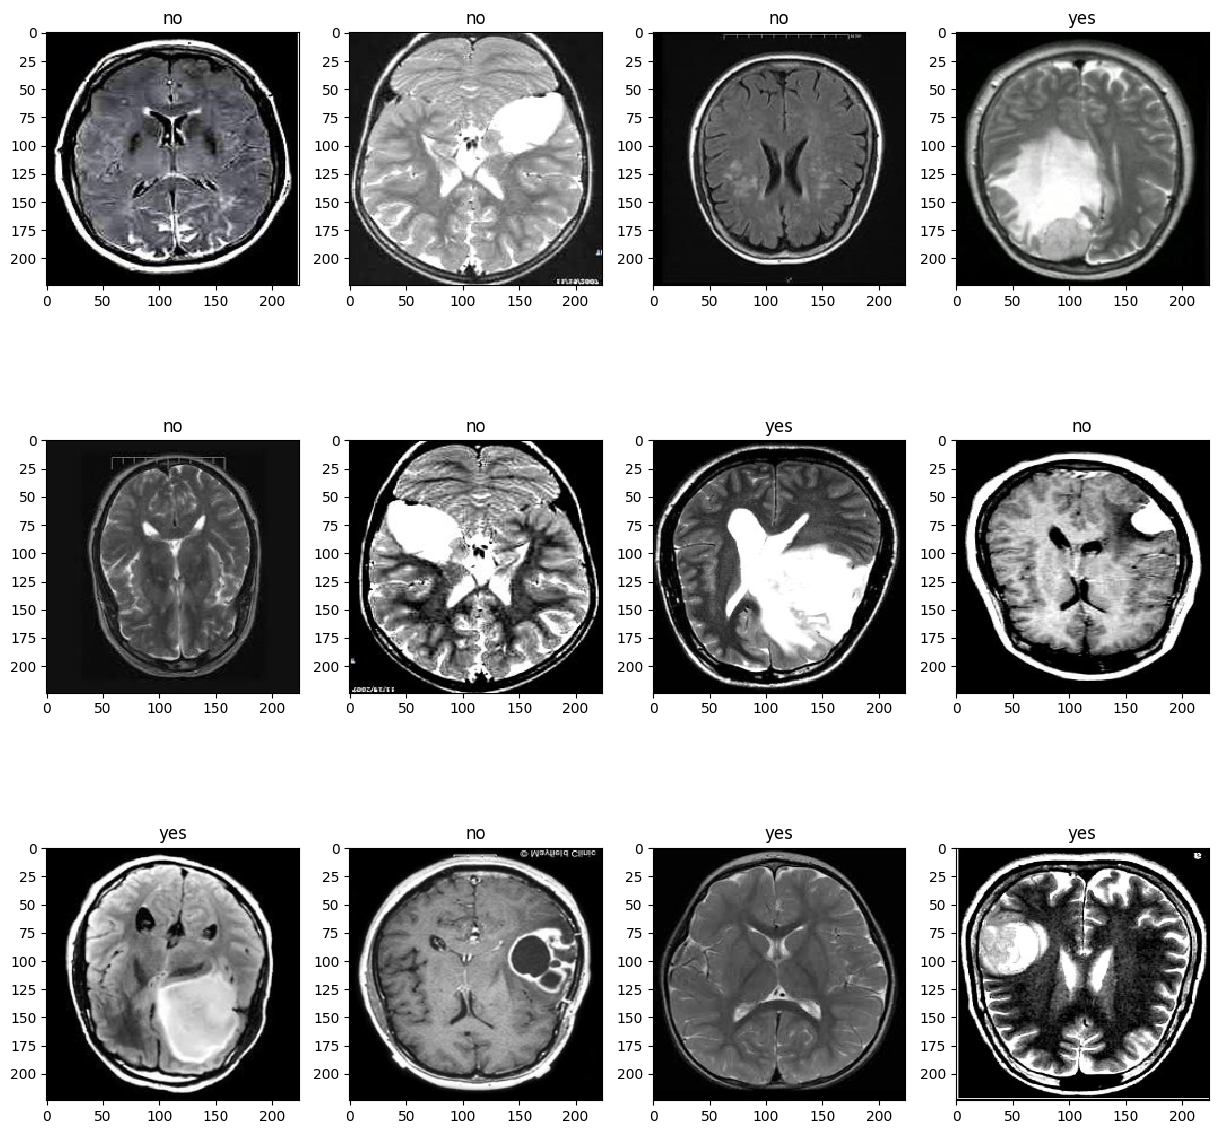

In [5]:
# # Display first 12 images of moles, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('yes')
    else:
        ax.title.set_text('no')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

# Data Generator

In [6]:
BATCH_SIZE = 16

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Model: ResNet50

In [7]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [8]:
K.clear_session()
gc.collect()

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

model = build_model(resnet ,lr = 1e-4)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 3842      
                                                                 
Total params: 18,333,506
Trainable params: 18,100,610
No

C:\Users\COMP\anaconda3\envs\brain\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [9]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max')

# Training & Evaluation

In [10]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

C:\Users\COMP\anaconda3\envs\brain\lib\site-packages\ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
34/33 [==============================] - ETA: -10s - loss: 0.5980 - accuracy: 0.6996WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr

Epoch 00001: saving model to weights.best.hdf5
33/33 [==============================] - 789s 23s/step - loss: 0.5980 - accuracy: 0.6996 - val_loss: 1.6542 - val_accuracy: 0.4925 - lr: 1.0000e-04
Epoch 2/20
34/33 [==============================] - ETA: -10s - loss: 0.4205 - accuracy: 0.8116WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr

Epoch 00002: saving model to weights.best.hdf5
33/33 [==============================] - 766s 23s/step - loss: 0.4205 - accuracy: 0.8116 - val_loss: 0.3811 - val_accuracy: 0.9030 - lr: 1.0000e-04
Epoch 3/20
34/33 [==============================] - ETA: -10s - loss: 0.3899 - accuracy: 0

Epoch 19/20
34/33 [==============================] - ETA: -10s - loss: 0.2079 - accuracy: 0.9198WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr

Epoch 00019: saving model to weights.best.hdf5
33/33 [==============================] - 753s 23s/step - loss: 0.2079 - accuracy: 0.9198 - val_loss: 0.0354 - val_accuracy: 0.9925 - lr: 1.0000e-04
Epoch 20/20
34/33 [==============================] - ETA: -10s - loss: 0.1823 - accuracy: 0.9403WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr

Epoch 00020: saving model to weights.best.hdf5
33/33 [==============================] - 761s 23s/step - loss: 0.1823 - accuracy: 0.9403 - val_loss: 0.0265 - val_accuracy: 0.9851 - lr: 1.0000e-04


In [13]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

<AxesSubplot:>

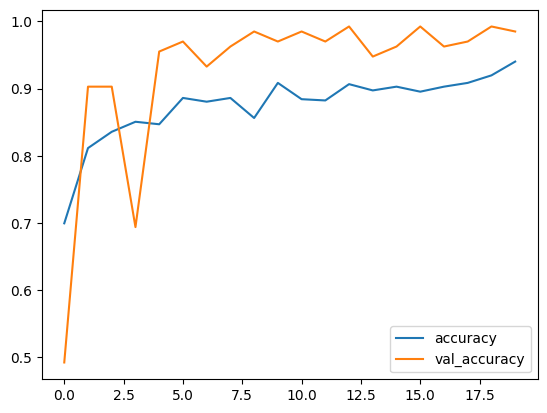

In [16]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

<AxesSubplot:>

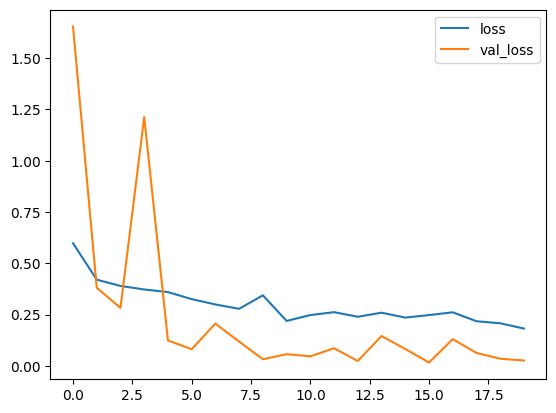

In [15]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

# Prediction

In [17]:
model.load_weights("weights.best.hdf5")

In [18]:
Y_val_pred = model.predict(x_val)

accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

In [20]:
Y_pred = model.predict(X_test)

In [21]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\COMP\anaconda3\envs\brain\lib\site-packages\ipykernel_launcher.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  
100%|██████████| 10/10 [47:55<00:00, 287.52s/it]


### Confusion Matrix

Confusion matrix, without normalization
[[385  15]
 [ 26 374]]


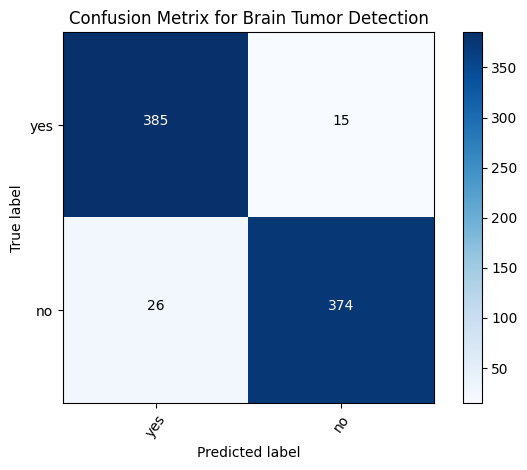

In [22]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['yes', 'no']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Brain Tumor Detection')

Confusion matrix, without normalization
[[345  55]
 [ 31 369]]


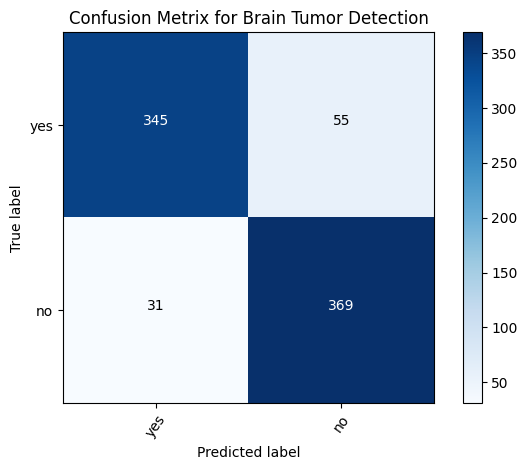

In [23]:
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label =['yes', 'no']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Brain Tumor Detection')

### Classification Report

In [24]:
from sklearn.metrics import classification_report
classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

'              precision    recall  f1-score   support\n\n           0       0.92      0.86      0.89       400\n           1       0.87      0.92      0.90       400\n\n    accuracy                           0.89       800\n   macro avg       0.89      0.89      0.89       800\nweighted avg       0.89      0.89      0.89       800\n'

### ROC and AUC

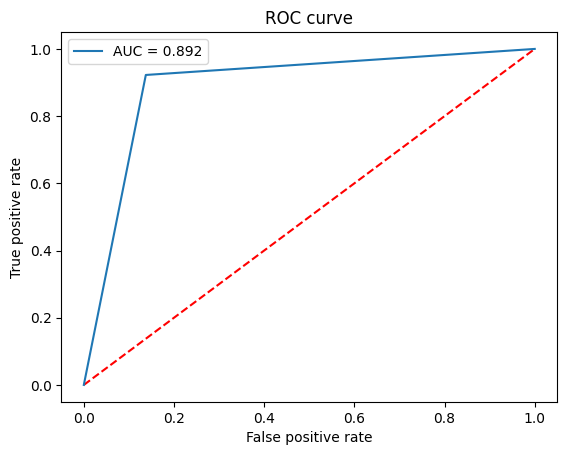

In [25]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

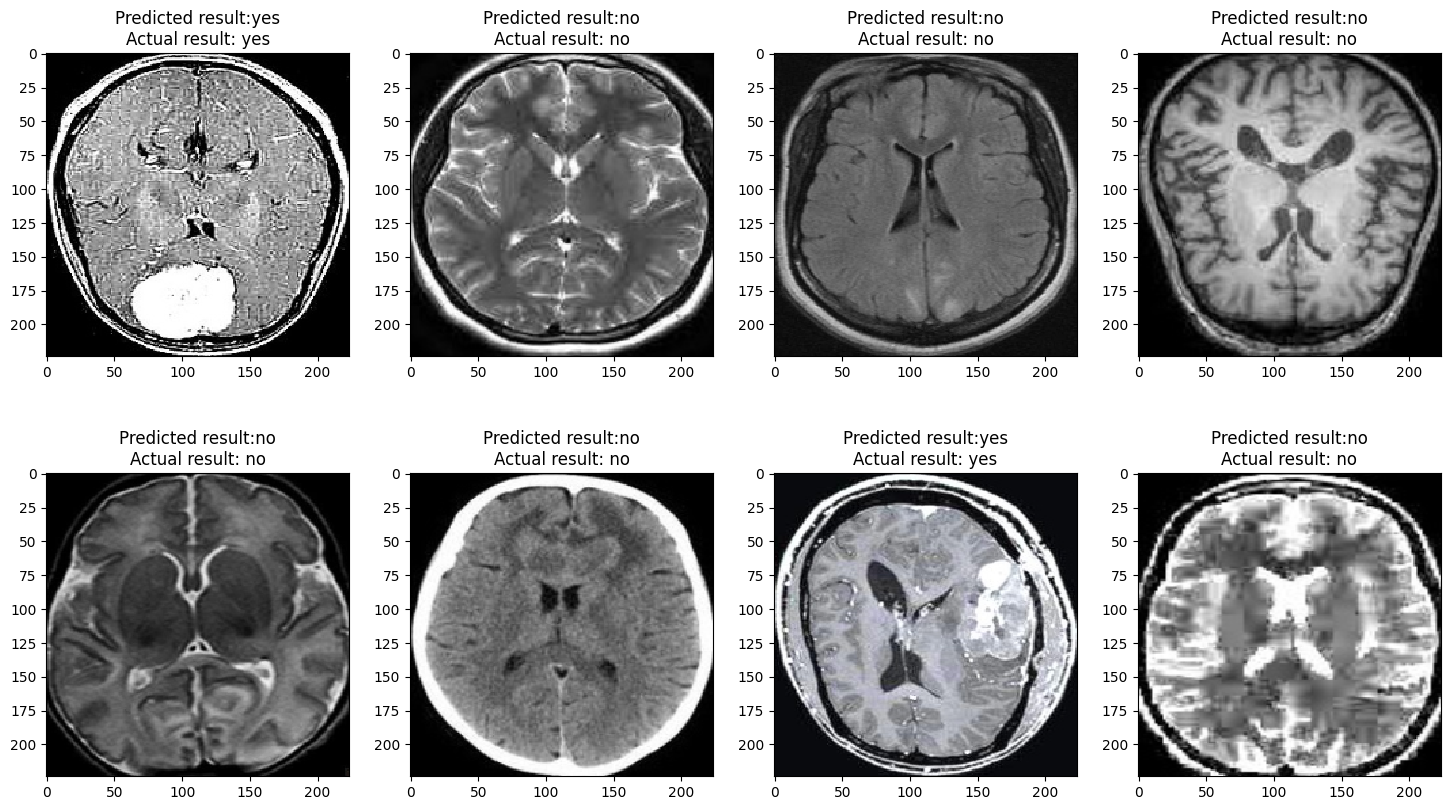

In [26]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of yes or no
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "yes"
    else:
        return "no"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()

VGG_NET_CODE

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, Activation, Dropout
from keras.models import Model
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from keras.models import Sequential
import keras  
from keras.applications.vgg16 import VGG16
#from  keras.applications import VGG16, ResNet50
from keras import backend as K
from tensorflow.keras import optimizers
import os
import numpy as np
import errno
from matplotlib import pyplot as plt
import time

In [28]:
# test >> yes = 62 | no - 34
# training >> yes =  145 | no - 81

# NN Parameters
image_size = 224     
train_batchsize = 10  
epochs = 90

In [29]:
# Image Dataset Directory
train_dir = 'data\\train' #'dataset/train'

def make_sure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

In [30]:
# Train datagenerator
BATCH_SIZE = 16

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )


In [31]:
def vgg16_finetuned():

  vgg_conv = VGG16(weights='imagenet',
            include_top=False,
            input_shape=(image_size, image_size, 3))

  for layer in vgg_conv.layers[:-2]:
    layer.trainable = False

  model = Sequential()
  model.add(vgg_conv)
  model.add(Flatten())
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(1024, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(2, activation= 'sigmoid'))

  return model

In [32]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 90:
        lr *= 0.5e-3
    elif epoch > 80:
        lr *= 1e-3
    elif epoch > 60:
        lr *= 1e-2
    elif epoch > 40:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [33]:
K.clear_session()
gc.collect()

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)


 


model = build_model(resnet ,lr = 1e-4)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 3842      
                                                                 
Total params: 18,333,506
Trainable params: 18,100,610
No

C:\Users\COMP\anaconda3\envs\brain\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [34]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="vgg.weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max')

In [35]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=15,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

C:\Users\COMP\anaconda3\envs\brain\lib\site-packages\ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/15
34/33 [==============================] - ETA: -11s - loss: 0.6048 - accuracy: 0.6996WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr

Epoch 00001: saving model to vgg.weights.best.hdf5
33/33 [==============================] - 879s 25s/step - loss: 0.6048 - accuracy: 0.6996 - val_loss: 0.6696 - val_accuracy: 0.8134 - lr: 1.0000e-04
Epoch 2/15
34/33 [==============================] - ETA: -11s - loss: 0.4211 - accuracy: 0.8172WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr

Epoch 00002: saving model to vgg.weights.best.hdf5
33/33 [==============================] - 851s 25s/step - loss: 0.4211 - accuracy: 0.8172 - val_loss: 0.4815 - val_accuracy: 0.8582 - lr: 1.0000e-04
Epoch 3/15
34/33 [==============================] - ETA: -11s - loss: 0.4389 - acc

**PREDICTION**


In [36]:
model.load_weights("vgg.weights.best.hdf5")

In [37]:
Y_val_pred = model.predict(x_val)

In [38]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.9850746268656716

In [39]:
Y_pred = model.predict(X_test)

In [40]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\COMP\anaconda3\envs\brain\lib\site-packages\ipykernel_launcher.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  
100%|██████████| 10/10 [1:07:47<00:00, 406.78s/it]


**TESTING**

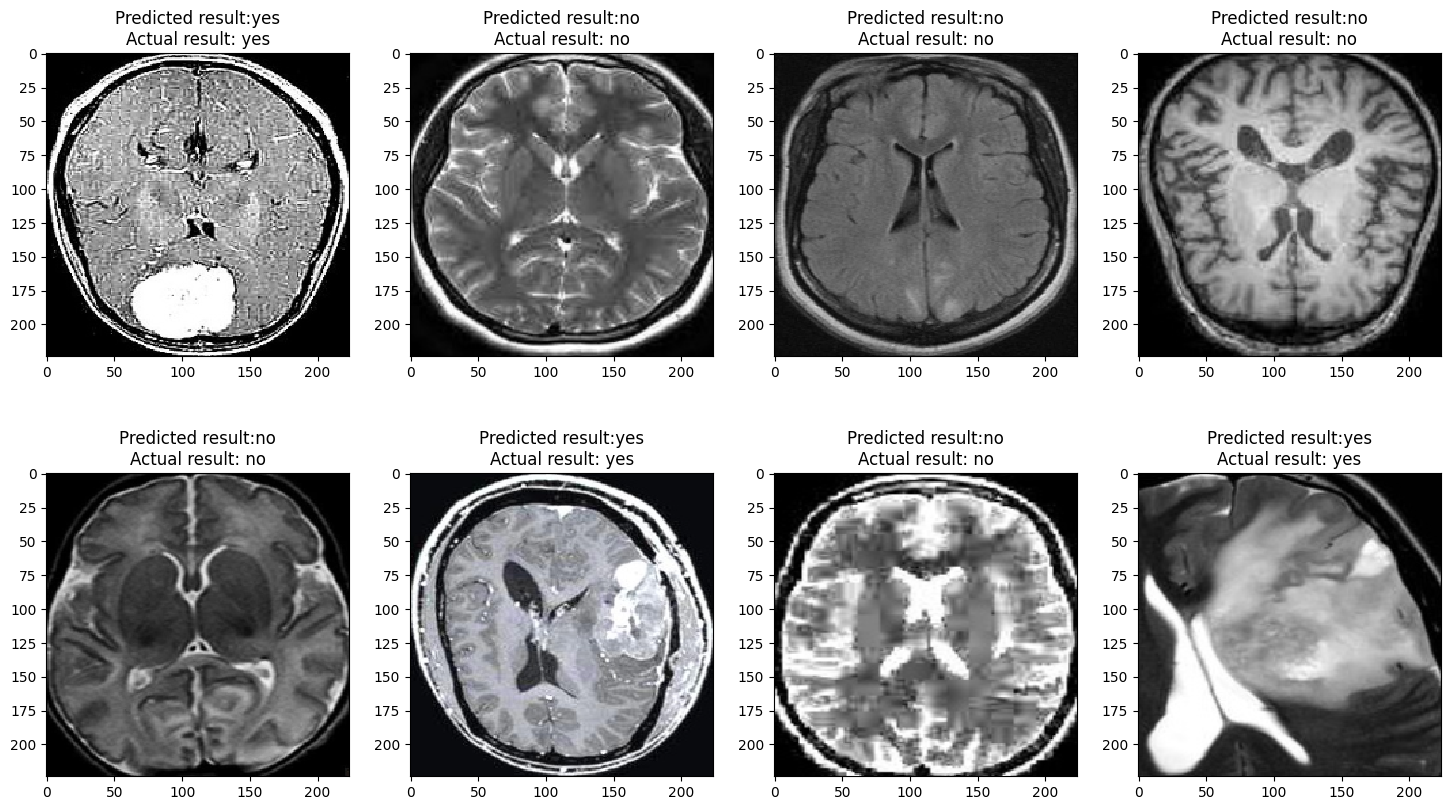

In [41]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "yes"
    else:
        return "no"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()